In [1]:
import twitter
consumer_key = "W1kmCYP1qb69WUL5eTxwBtyeo"
consumer_secret = "FyVAetxryo8z3XIzkLhwPLYPU1LmWO8rsW2Bk2XyLq2c9iDLW4"
access_token = "4853079850-bsq4cvPpi7XfjVH1VH2O9QuVOiEmcEoHBW6Vzax"
access_token_secret = "qKCd0PkCP1vukm9OyEJkxKeHGNWLBAroO3qyiIQUYzMwq"
authorization = twitter.OAuth(access_token, access_token_secret, consumer_key, consumer_secret)
t = twitter.Twitter(auth=authorization)

In [2]:
import os
data_folder = os.path.join(os.path.expanduser("~"),"Datamining","ch7", "Data", "twitter")
output_filename = os.path.join(data_folder, "python_tweets.json")

In [3]:
original_users = []
tweets = []
user_ids = {}

In [4]:
search_results = t.search.tweets(q="python", count=100)['statuses']
for tweet in search_results:
    if 'text' in tweet:
        original_users.append(tweet['user']['screen_name'])
        user_ids[tweet['user']['screen_name']] = tweet['user']['id']
        tweets.append(tweet['text'])

In [7]:
model_filename = os.path.join(os.path.expanduser("~"), "Datamining/ch6/Models", "twitter", "python_context.pkl")

In [8]:
import spacy
from sklearn.base import TransformerMixin
nlp = spacy.load('en')
class BagOfWords(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        results = []
        for document in X:
            row = {}
            for word in list(nlp(document)):
                if len(word.text.strip()):
                    row[word.text] = True
                    results.append(row)
        return results

In [9]:
from sklearn.externals import joblib
context_classifier = joblib.load(model_filename)

In [10]:
y_pred = context_classifier.predict(tweets)

In [11]:
relevant_tweets = [tweets[i] for i in range(len(tweets)) if y_pred[i] == 1]
relevant_users = [original_users[i] for i in range(len(tweets)) if y_pred[i] == 1]

In [12]:
import time

def get_friends(t, user_id):
    friends = []
    cursor = -1
    while cursor != 0: 
        try:
            results = t.friends.ids(user_id= user_id, cursor=cursor, count=5000)
            friends.extend([friend for friend in results['ids']])
            cursor = results['next_cursor'] 
            if True or len(friends) >= 10000:
                break
        except TypeError as e:
            if results is None:
                print("You probably reached your API limit, waiting for 5 minutes")
                sys.stdout.flush() 
                time.sleep(5*60) # 5 minute wait 
            else: 
                # Some other error happened, so raise the error as normal
                raise e
        except twitter.TwitterHTTPError as e:
            print(e)
            break
        finally:
            # Break regardless -- this stops us going over our API limit
            time.sleep(60)
    return friends

In [13]:
friends = {} 
for screen_name in relevant_users:
    user_id = user_ids[screen_name]
    friends[user_id] = get_friends(t, user_id)

Twitter sent status 404 for URL: 1.1/friends/ids.json using parameters: (count=5000&cursor=-1&oauth_consumer_key=W1kmCYP1qb69WUL5eTxwBtyeo&oauth_nonce=1772187542020453605&oauth_signature_method=HMAC-SHA1&oauth_timestamp=1552755982&oauth_token=4853079850-bsq4cvPpi7XfjVH1VH2O9QuVOiEmcEoHBW6Vzax&oauth_version=1.0&user_id=1100706972209463301&oauth_signature=rPyRKqJCRhwQTWE9qwDRBuTtiYM%3D)
details: {'errors': [{'message': 'Sorry, that page does not exist.', 'code': 34}]}


In [14]:
friends = {user_id:friends[user_id] 
           for user_id in friends
           if len(friends[user_id]) > 0}

In [15]:
from collections import defaultdict
def count_friends(friends): 
    friend_count = defaultdict(int)
    for friend_list in friends.values(): 
        for friend in friend_list:
            friend_count[friend] += 1 
    return friend_count

In [16]:
friend_count = count_friends(friends)
from operator import itemgetter
best_friends = sorted(friend_count, key=friend_count.get, reverse=True)

In [17]:
best_friends

[25073877,
 813286,
 44196397,
 50393960,
 11348282,
 19725644,
 807095,
 822215679726100480,
 2916305152,
 34743251,
 63873759,
 783214,
 51241574,
 822215673812119553,
 5402612,
 428333,
 20536157,
 1339835893,
 4263007693,
 1652541,
 759251,
 15066876,
 571202103,
 5988062,
 87818409,
 750554018,
 16589206,
 1536791610,
 2460368252,
 169686021,
 742143,
 14159148,
 10228272,
 1262776610,
 8161232,
 47786101,
 580097412,
 14260960,
 23022687,
 180505807,
 17995040,
 13334762,
 500704345,
 218379543,
 39344374,
 1636590253,
 816653,
 169115069,
 20479813,
 1344951,
 19697415,
 9475182,
 111457430,
 830130240793899009,
 1367531,
 17093617,
 555031989,
 15804774,
 29442313,
 153966123,
 14173315,
 2467791,
 292929271,
 52551600,
 62513246,
 21360280,
 860076704,
 14293310,
 2736397896,
 16129920,
 398087684,
 15143478,
 14847675,
 17471979,
 14075928,
 818910970567344128,
 28785486,
 241382835,
 9300262,
 37710752,
 15438913,
 16228398,
 216776631,
 19397785,
 12,
 15210670,
 15473958,


In [18]:
import sys

In [19]:
while len(friends) < 150:
    for user_id in best_friends:
        if user_id in friends:
            continue
        print(user_id)
        sys.stdout.flush()
        friends[user_id] = get_friends(t, user_id) 
        for friend in friends[user_id]: 
            friend_count[friend] += 1
        best_friends = sorted(friend_count.items(), key=itemgetter(1), reverse=True)
        break

25073877
(25073877, 23)
(813286, 21)
(44196397, 19)
(50393960, 16)
(11348282, 16)
(19725644, 14)
(807095, 13)
(822215679726100480, 13)
(2916305152, 13)
(352145373, 12)
(352145373, 13)
(352145373, 14)
(352145373, 15)
(352145373, 16)
(352145373, 17)
(352145373, 18)
(352145373, 19)
(352145373, 20)
(352145373, 21)
(352145373, 22)
(352145373, 23)
(352145373, 24)
(352145373, 25)
(352145373, 26)
(352145373, 27)
(352145373, 28)
(352145373, 29)
(352145373, 30)
(352145373, 31)
(352145373, 32)
(352145373, 33)
(352145373, 34)
(352145373, 35)
(352145373, 36)
(352145373, 37)
(352145373, 38)
(352145373, 39)
(352145373, 40)
(352145373, 41)
(352145373, 42)
(352145373, 43)
(352145373, 44)
(352145373, 45)
(352145373, 46)
(352145373, 47)
(352145373, 48)
(352145373, 49)
(352145373, 50)
(352145373, 51)
(352145373, 52)
(352145373, 53)
(352145373, 54)
(352145373, 55)
(352145373, 56)
(352145373, 57)
(352145373, 58)
(352145373, 59)
(352145373, 60)
(352145373, 61)
(352145373, 62)
(352145373, 63)
(352145373, 64)


In [20]:
len(friends)

150

In [21]:
data_folder


'C:\\Users\\abhijit\\Datamining\\ch7\\Data\\twitter'

In [22]:
import json
friends_filename = os.path.join(data_folder, "python_friends.json")

In [73]:
friends_filename

'C:\\Users\\abhijit\\Datamining\\ch7\\Data\\twitter\\python_friends.json'

In [72]:

with open("data_folder", 'w') as outf1:
    json.dump(friends, outf1)


TypeError: {1079641484310134784, 913203265466257408, 1044003942420508672, 764962305578786816, 953041598727716864, 1106186244864790533, 3087733248, 1052219041815891968, 854381836759429122, 1130451463, 953042315802628097, 817894503130480641, 1091790898566959107, 1049061851819114501, 979165104070590465, 711356961107918849, 827258161841135623, 857260759675535362, 456988174, 963480595, 1107146772, 1408003598, 475988505, 4196983835, 918169628, 92903456, 2402918946, 26637348, 118756393, 22545453, 16228398, 30354991, 304139821, 558372913, 150078976, 22044727, 88784440, 487297085, 1074480192, 970207298, 20270659, 37836873, 2334193741, 1973354066, 374858323, 14345812, 939091, 1480852568, 1077214808, 2655321690, 17976923, 18646108, 38495835, 32765534, 23022687, 51241574, 51263592, 36375662, 2566535282, 498961017, 14669951, 921116757510754304, 983766825610694656, 1085686909979054080, 993901390014697472, 394797701, 878739731219189761, 1044236500165120001, 930552552302792705, 734783792502575105, 1656057482, 1080894931311431682, 973917722852642818, 717617292, 131948686, 913812620, 962852020028755971, 426802833, 19394188, 568825492, 14336662, 86523551, 3331851939, 138134695, 4914384040, 116835497, 37666984, 476256944, 807095, 216881337, 430048955, 146241212, 1021269114696822784, 71627462, 376037062, 3835337419, 249677516, 221990097, 168736979, 20776147, 25073877, 1512763099, 17060573, 5988062, 29166305, 240107748, 388555493, 27637990, 975200486, 813286, 1250265324, 1599608046, 18020081, 966729216, 18956020, 19426551, 2163267319, 52136185, 2228878592, 900261083172052992, 15675138, 988933731934134272, 16076032, 39308549, 861246117689925633, 988573326376427520, 928621382069493761, 29442313, 2835451658, 393469195, 905563470707515394, 2353605901, 628706570, 26257166, 62610707, 19726613, 233842454, 117777690, 238763290, 566584602, 17995040, 16827173, 761195815, 324236072, 1055907624, 95092020, 983780665152815104, 287504183, 721341752, 201733435, 97963837, 287413569, 3777267019, 15091022, 12765522, 403830102, 6395222, 15745368, 432895323, 2361859933, 306389855, 196428643, 135019364, 29310316, 61047667, 15450996, 68034431, 16129920, 1082349141806723072, 20174209, 901915347556675584, 1094997200080433152, 1078693601356509184, 871466086293794817, 235441031, 1056549203462172672, 113047940, 53238154, 822215673812119553, 709629045604880384, 2359926157, 23083404, 92985745, 19417492, 260114837, 818910970567344128, 1249982359, 19910041, 19173787, 3054376353, 21829541, 381648806, 471672239, 818927131883356161, 730559311886336000, 1079776144524754944, 1042970598056574976, 169686021, 2828212668, 237348797, 31540671, 10615232, 39288259, 39384517, 342863309, 2957991374, 807442387, 846137120209190912, 27966935, 250188760, 19217369, 304137182, 36771809, 62587361, 816625461195407360, 1367531, 1064042478, 866454404, 16056306, 821938676, 19739126, 122207745, 17494010, 29216764, 138203134} is not JSON serializable

In [24]:
with open(friends_filename) as inf:
    friends = json.load(inf)

JSONDecodeError: Expecting ',' delimiter: line 1 column 12325 (char 12324)

In [25]:
len(friends), type(friends)

(150, dict)

In [26]:
import networkx as nx 
G = nx.DiGraph()

In [27]:
main_users = friends.keys() 
G.add_nodes_from(main_users)

In [28]:
for user_id in friends:
    for friend in friends[user_id]:
        if str(friend) in main_users: 
            G.add_edge(user_id, friend) 

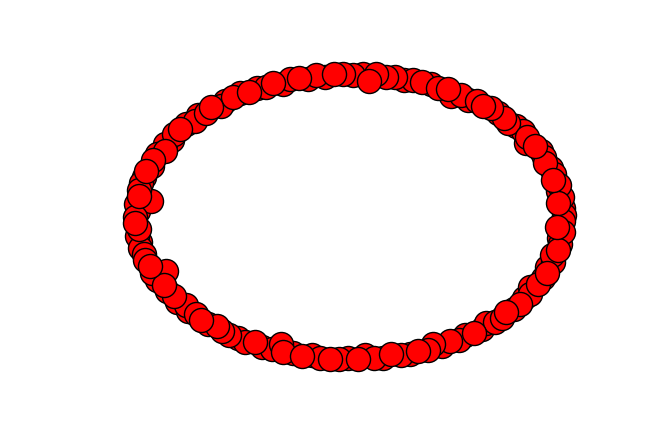

In [32]:
%matplotlib inline 
nx.draw(G)

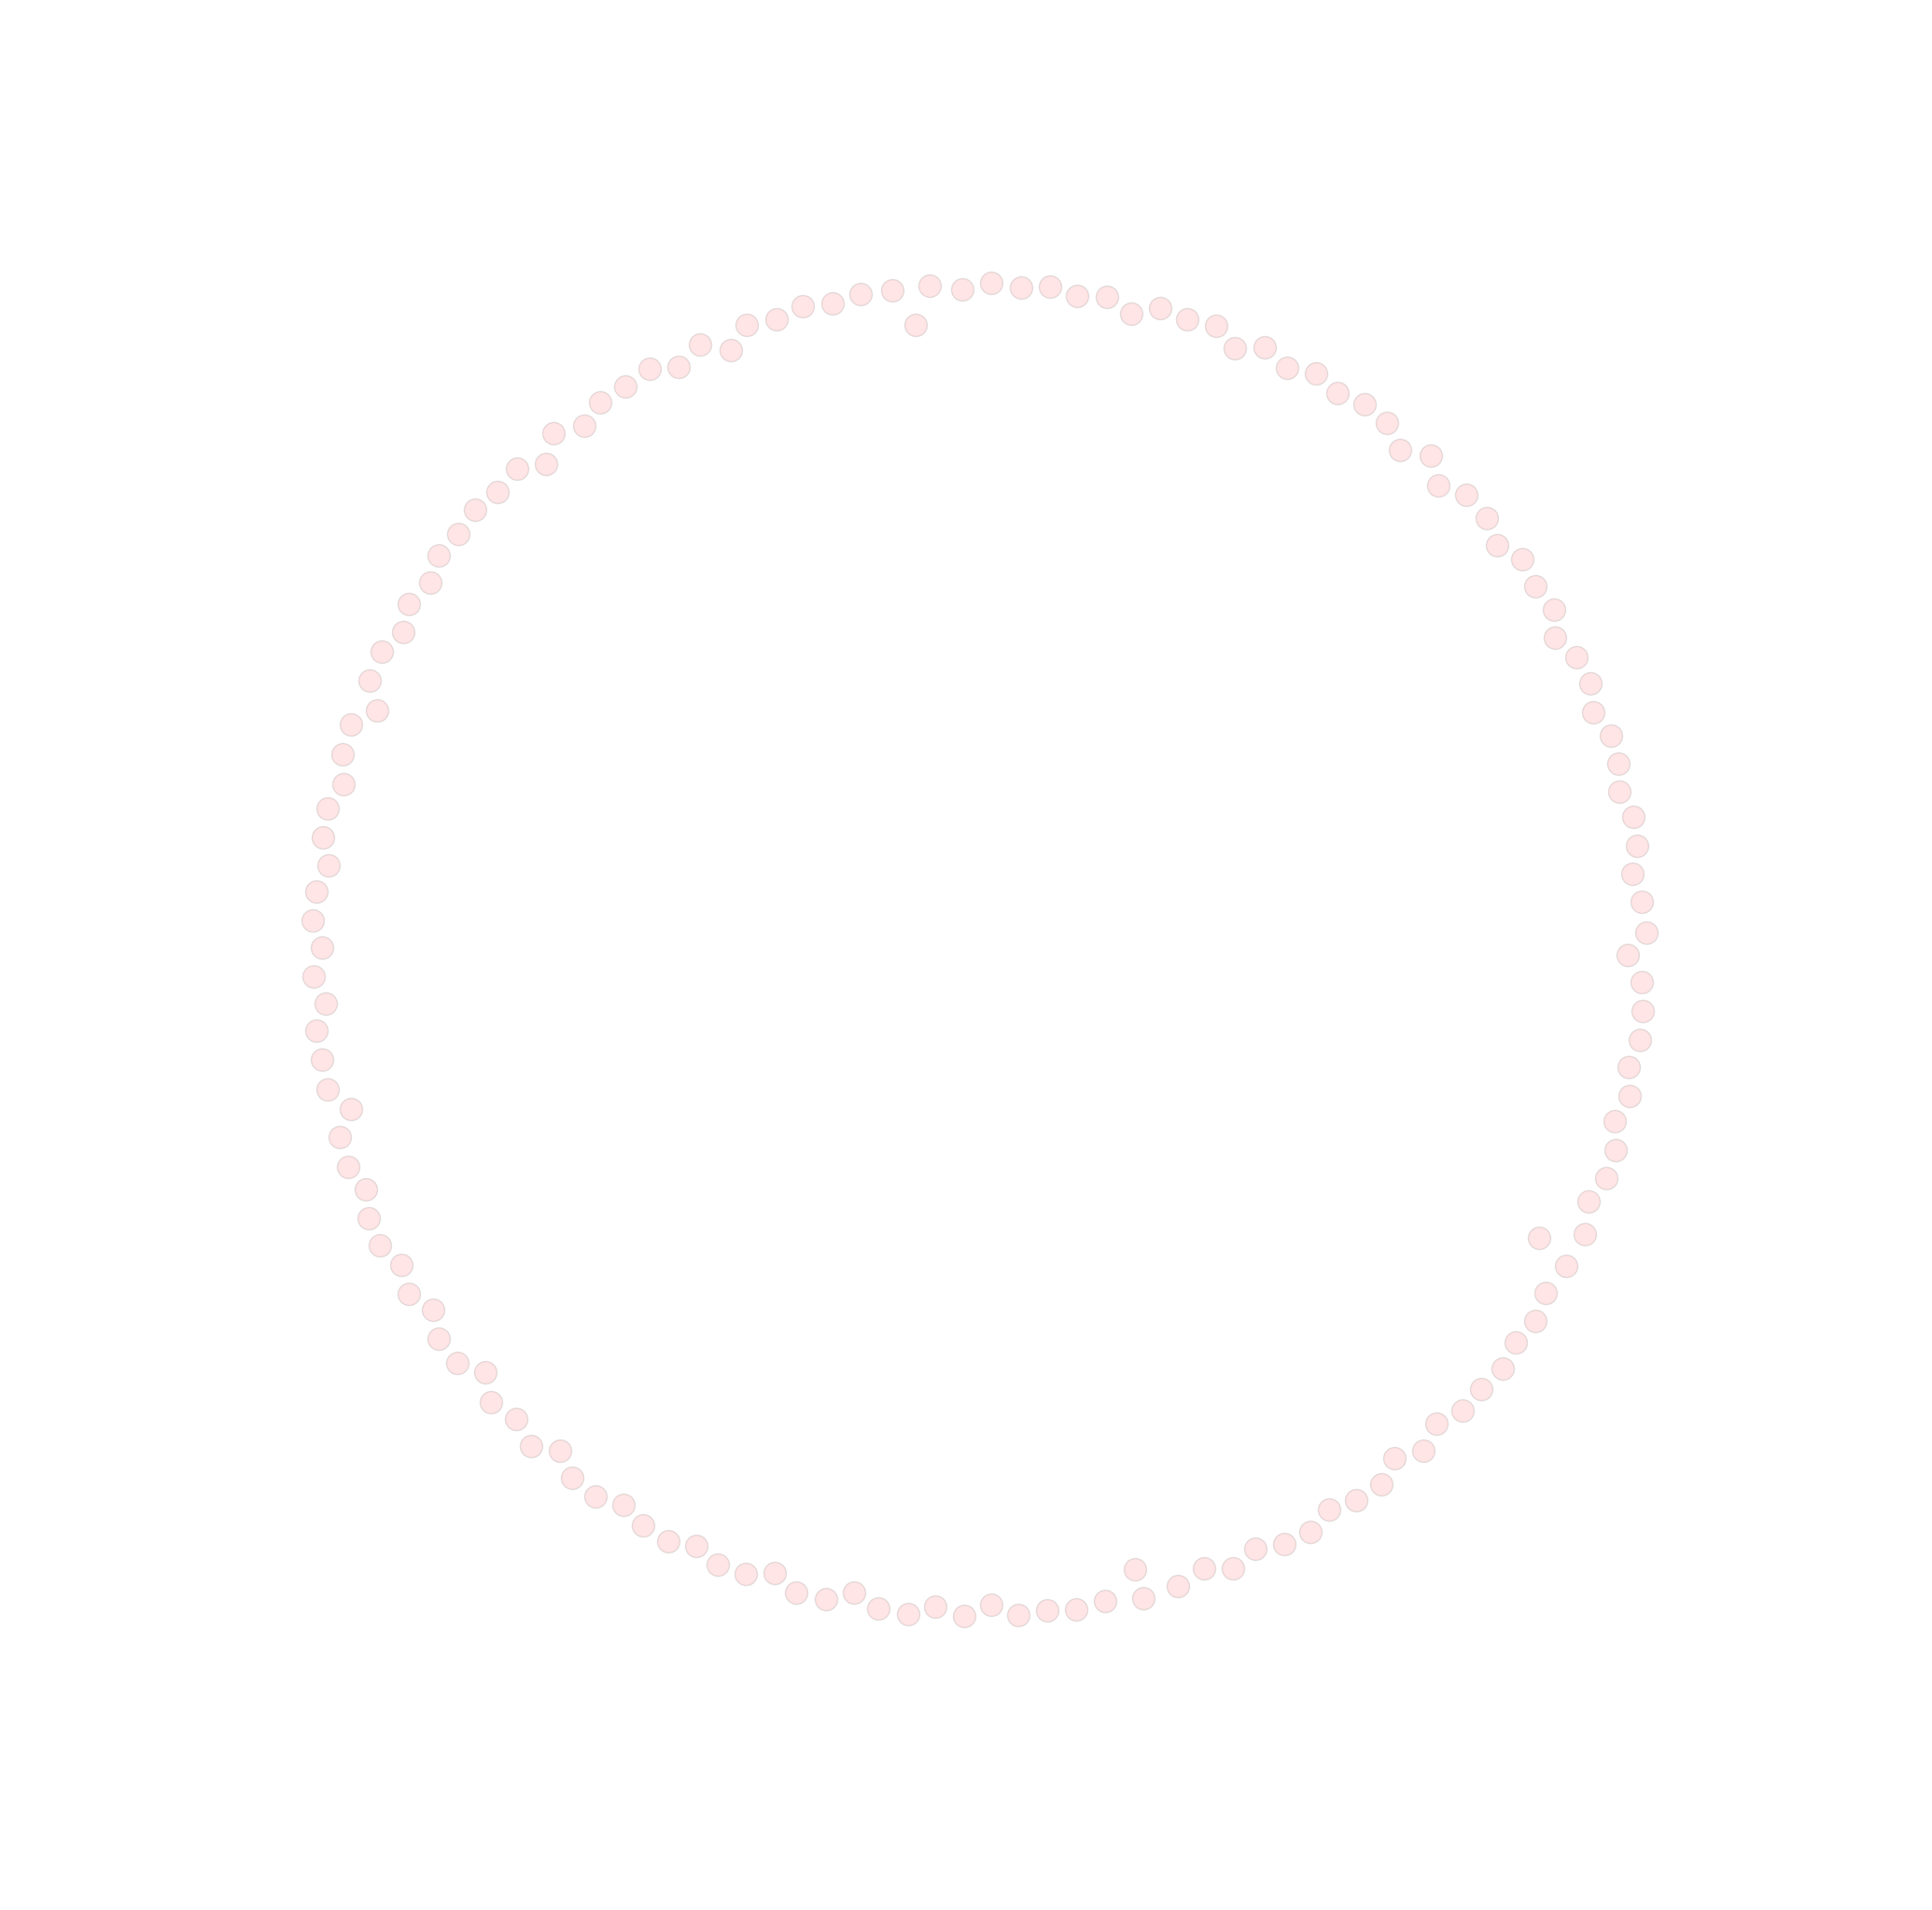

In [33]:
from matplotlib import pyplot as plt
plt.figure(3,figsize=(20,20))
nx.draw(G, alpha=0.1, edge_color='b')

In [34]:
friends = {user: set(friends[user]) for user in friends}

In [35]:
def compute_similarity(friends1, friends2):
    return len(friends1 & friends2) / (len(friends1 | friends2) + 1e-6)

In [36]:
def create_graph(followers, threshold=0): 
    G = nx.Graph()
    for user1 in friends.keys(): 
        for user2 in friends.keys(): 
            if user1 == user2:
                continue
            weight = compute_similarity(friends[user1], friends[user2])
            if weight >= threshold:
                G.add_node(user1) 
                G.add_node(user2)
                G.add_edge(user1, user2, weight=weight)
    return G

In [37]:
G = create_graph(friends)

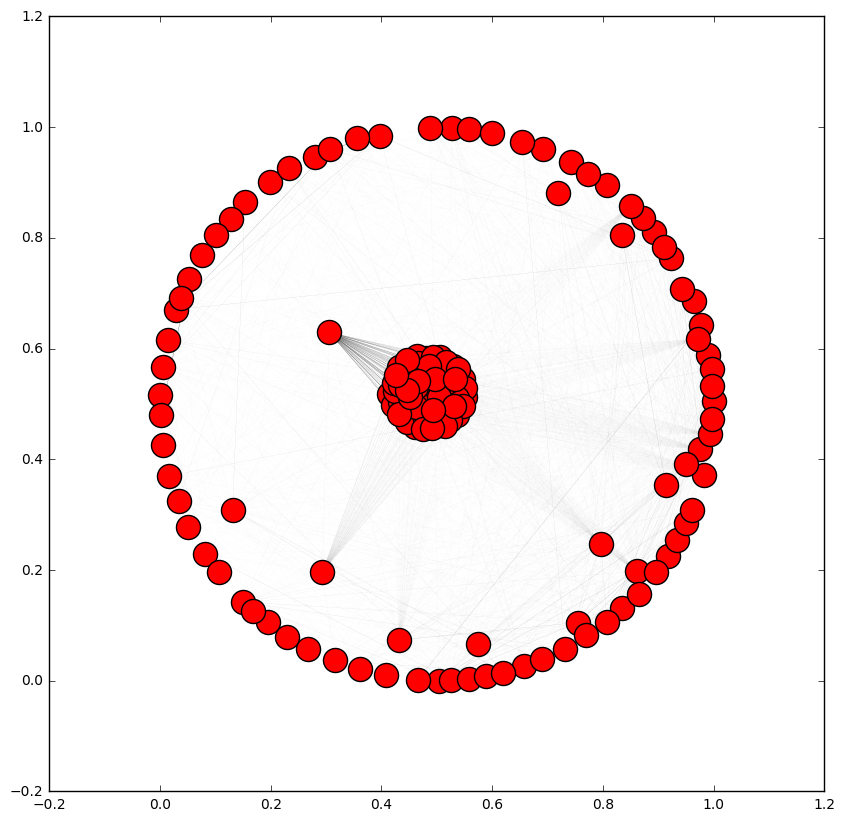

In [40]:
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
edgewidth = [ d['weight'] for (u,v,d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, width=edgewidth)

In [41]:
G = create_graph(friends, 0.1)

In [42]:
sub_graphs = nx.connected_component_subgraphs(G)

In [43]:
for i, sub_graph in enumerate(sub_graphs):
    n_nodes = len(sub_graph.nodes()) 
    print("Subgraph {0} has {1} nodes".format(i, n_nodes))

Subgraph 0 has 63 nodes
Subgraph 1 has 2 nodes
Subgraph 2 has 2 nodes


In [44]:
G = create_graph(friends, 0.25) 
sub_graphs = nx.connected_component_subgraphs(G) 
for i, sub_graph in enumerate(sub_graphs): 
    n_nodes = len(sub_graph.nodes()) 
    print("Subgraph {0} has {1} nodes".format(i, n_nodes))

Subgraph 0 has 63 nodes


In [45]:
sub_graphs = nx.connected_component_subgraphs(G) 
n_subgraphs = nx.number_connected_components(G)

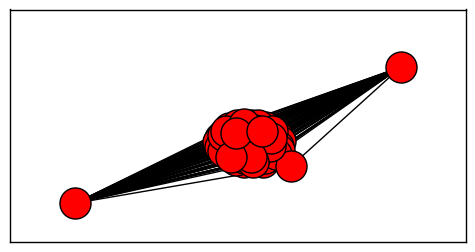

In [60]:
sub_graphs = nx.connected_component_subgraphs(G) 
n_subgraphs = nx.number_connected_components(G)
fig = plt.figure(figsize=(20, (n_subgraphs * 3)))
for i, sub_graph in enumerate(sub_graphs):   
    ax = fig.add_subplot(int(n_subgraphs / 3)+1, 3, i+1)
    ax.get_xaxis().set_visible(False) 
    ax.get_yaxis().set_visible(False)
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, sub_graph.nodes(), ax=ax, node_size=500)
    nx.draw_networkx_edges(G, pos, sub_graph.edges(), ax=ax)


In [61]:
import numpy as np
from sklearn.metrics import silhouette_score

def compute_silhouette(threshold, friends):
    G = create_graph(friends, threshold=threshold) 
    if len(G.nodes()) < 2:
        return -99
    sub_graphs = nx.connected_component_subgraphs(G)

    if not (2 <= nx.number_connected_components(G) < len(G.nodes()) - 1): 
        return -99

    label_dict = {}
    for i, sub_graph in enumerate(sub_graphs): 
        for node in sub_graph.nodes(): 
            label_dict[node] = i

    labels = np.array([label_dict[node] for node in G.nodes()])
    X = nx.to_scipy_sparse_matrix(G).todense()
    X = 1 - X
    return silhouette_score(X, labels, metric='precomputed')

In [63]:
def inverted_silhouette(threshold, friends):
    return -compute_silhouette(threshold, friends)

In [64]:
from scipy.optimize import minimize
result = minimize(inverted_silhouette, 0.1, args=(friends,))

In [67]:
print(result)

      fun: -0.8978305112218786
 hess_inv: array([[1]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.1])
